[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/069_pytorch_benchmarking/069_pytorch_benchmarking.ipynb)

# Pytorch - Benchmarking

En el post anterior aprendimos a utilizar el `Profiler` de `Pytorch` para poder evaluar nuestro código y encontrar posibles cuellos de botella y mejoras que nos ayuden a entrenar nuestras redes neuronales de manera rápida y eficiente. En este post vamos a ver otra herramienta útil que nos ofrece esta librería para poder comparar diferentes implementaciones de una misma funcionalidad y poder saber así cual es la mejor.

Para este ejemplo vamos a entrenar un calisficador de imágenes usando el dataset de imágenes de satélite [EuroSAT](https://github.com/phelber/eurosat).

## Cargando datos

Existen muchas maneras de cargar nuestras imágenes para entrenar un modelo, y unas serán más eficientes que otras. Vamos a empezar definiendo un `Dataset` simple que cargará una imagen, la normalizará y la convertirá en tensor.

In [1]:
import os
from sklearn.model_selection import train_test_split

def setup(path='./data', test_size=0.2, random_state=42):

    classes = sorted(os.listdir(path))

    print("Generating images and labels ...")
    images, encoded = [], []
    for ix, label in enumerate(classes):
        _images = os.listdir(f'{path}/{label}')
        images += [f'{path}/{label}/{img}' for img in _images]
        encoded += [ix]*len(_images)
    print(f'Number of images: {len(images)}')

     # train / val split
    print("Generating train / val splits ...")
    train_images, val_images, train_labels, val_labels = train_test_split(
        images,
        encoded,
        stratify=encoded,
        test_size=test_size,
        random_state=random_state
    )

    print("Training samples: ", len(train_labels))
    print("Validation samples: ", len(val_labels))
    
    return classes, train_images, train_labels, val_images, val_labels

classes, train_images, train_labels, val_images, val_labels = setup('./data')

Generating images and labels ...
Number of images: 27000
Generating train / val splits ...
Training samples:  21600
Validation samples:  5400


In [2]:
import torch
import rasterio 
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, ix):
        img = rasterio.open(self.images[ix]).read((4, 3, 2))
        img = np.clip(img / 4000, 0, 1)
        img = torch.tensor(img, dtype=torch.float)  
        label = torch.tensor(self.labels[ix], dtype=torch.long)        
        return img, label
    
ds = {
    'train': Dataset(train_images, train_labels),
    'val': Dataset(val_images, val_labels)
}

In [3]:
batch_size = 32

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True),
    'val': torch.utils.data.DataLoader(ds['val'], batch_size=batch_size, shuffle=False)
}

imgs, labels = next(iter(dl['train']))
imgs.shape, labels.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

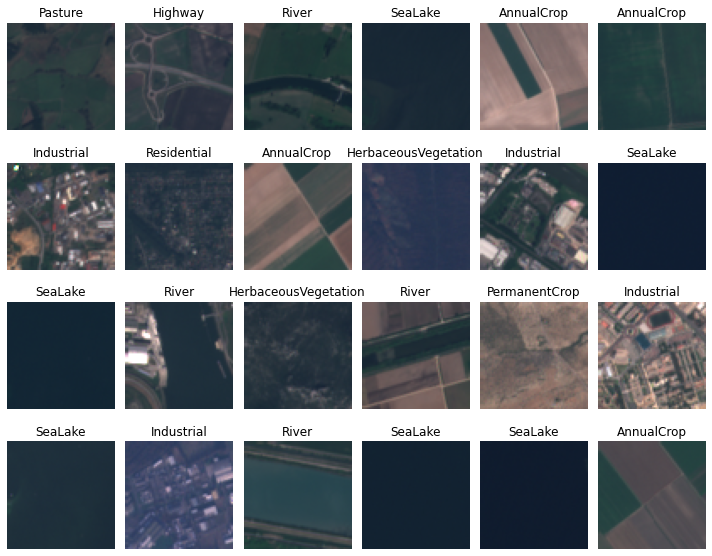

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
c, r = 6, 4
for j in range(r):
    for i in range(c):
        ix = j*c + i
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img.permute(1,2,0))
        ax.set_title(classes[label.item()])
        ax.axis('off')
plt.tight_layout()
plt.show()

`Python` nos ofrece varias maneras para medir el tiempo que tarda una función en ser ejectuada, sin embargo la cosa puede complicarse cuando empezamos a trabajar con código en asíncrono o `GPUs`. Vamos a empezar usando el módulo de `Python` `timeit`.

In [5]:
import timeit

def load_data(dl):
    for batch_ix, (imgs, labels) in enumerate(dl):
        shape = imgs.shape
        if batch_ix + 1 >= 10:
            break
        
t1 = timeit.Timer(
    stmt='load_data(dl)',
    setup='from __main__ import load_data',
    globals={'dl': dl['train']})

print(f'baseline:  {t1.timeit(10) / 100 * 1e6:>5.1f} us')

baseline:  56707.2 us


Ahora, vamos a probar una implementación del `Dataset` diferente, usando la liberría `skimage` en vez de `rasterio` para cargar las imágenes.

In [4]:
from skimage import io

class Dataset2(Dataset):
    def __init__(self, images, labels):
        super().__init__(images, labels)

    def __getitem__(self, ix):
        img = io.imread(self.images[ix])[...,(3,2,1)]
        img = np.clip(img / 4000, 0, 1)
        img = torch.tensor(img, dtype=torch.float).permute(2,0,1)  
        label = torch.tensor(self.labels[ix], dtype=torch.long)        
        return img, label
    
ds2 = {
    'train': Dataset2(train_images, train_labels),
    'val': Dataset2(val_images, val_labels)
}

dl2 = {
    'train': torch.utils.data.DataLoader(ds2['train'], batch_size=batch_size, shuffle=True),
    'val': torch.utils.data.DataLoader(ds2['val'], batch_size=batch_size, shuffle=False)
}

In [7]:
t2 = timeit.Timer(
    stmt='load_data(dl)',
    setup='from __main__ import load_data',
    globals={'dl': dl2['train']})

print(f'rasterio:  {t1.timeit(10) / 100 * 1e6:>5.1f} us')
print(f'skimage:  {t2.timeit(10) / 100 * 1e6:>5.1f} us')

rasterio:  60181.3 us
skimage:  15696.4 us


Como puedes ver, la segunda implementación es mucho más rápida 😬. `Pytorch` nos ofrece una solción de *benchmarking* muy similar en el paquete `benchmark`.

In [8]:
import torch.utils.benchmark as benchmark

t1 = benchmark.Timer(
    stmt='load_data(dl)',
    setup='from __main__ import load_data',
    globals={'dl': dl['train']})

t2 = benchmark.Timer(
    stmt='load_data(dl)',
    setup='from __main__ import load_data',
    globals={'dl': dl2['train']})

print(f'rasterio:  {t1.timeit(10)}')
print(f'skimage:  {t2.timeit(10)}')

rasterio:  <torch.utils.benchmark.utils.common.Measurement object at 0x7f2d455679d0>
load_data(dl)
setup: from __main__ import load_data
  565.39 ms
  1 measurement, 10 runs , 1 thread
skimage:  <torch.utils.benchmark.utils.common.Measurement object at 0x7f2d45250d30>
load_data(dl)
setup: from __main__ import load_data
  151.02 ms
  1 measurement, 10 runs , 1 thread


Vamos a probar otra implementación, ahora cambiando la manera en la que hacemos la normalización. En vez de usar `numpy` usaremos directamente `Pytorch`.

In [5]:
class Dataset3(Dataset):
    def __init__(self, images, labels):
        super().__init__(images, labels)

    def __getitem__(self, ix):
        img = io.imread(self.images[ix])[...,(3,2,1)]
        #img = np.clip(img / 4000, 0, 1)
        img = torch.tensor(img / 4000, dtype=torch.float).clip(0,1).permute(2,0,1)  
        label = torch.tensor(self.labels[ix], dtype=torch.long)        
        return img, label
    
ds3 = {
    'train': Dataset3(train_images, train_labels),
    'val': Dataset3(val_images, val_labels)
}

dl3 = {
    'train': torch.utils.data.DataLoader(ds3['train'], batch_size=batch_size, shuffle=True),
    'val': torch.utils.data.DataLoader(ds3['val'], batch_size=batch_size, shuffle=False)
}

In [10]:
t3 = benchmark.Timer(
    stmt='load_data(dl)',
    setup='from __main__ import load_data',
    globals={'dl': dl3['train']}
)

#print(f'rasterio:  {t1.timeit(10)}')
print(f'skimage:  {t2.timeit(10)}')
print(f'from_numpy:  {t3.timeit(10)}')

skimage:  <torch.utils.benchmark.utils.common.Measurement object at 0x7f2d45135dc0>
load_data(dl)
setup: from __main__ import load_data
  149.05 ms
  1 measurement, 10 runs , 1 thread
from_numpy:  <torch.utils.benchmark.utils.common.Measurement object at 0x7f2d45936550>
load_data(dl)
setup: from __main__ import load_data
  139.18 ms
  1 measurement, 10 runs , 1 thread


No hemos ganado mucho, pero algo es algo ! Por último, podemos comparar diferentes implementaciones usando varios parámteros, como el `batch size`, de la siguiente manera.

In [11]:
results = []
batch_sizes = [1, 32, 64, 1024]
for batch_size in batch_sizes:
    label = 'Load data'
    sub_label = f'[{batch_size}]'
    for num_threads in [1, 4]:
        dl = {
            'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True),
            'val': torch.utils.data.DataLoader(ds['val'], batch_size=batch_size, shuffle=False)
        }
        results.append(benchmark.Timer(
            stmt='load_data(dl)',
            setup='from __main__ import load_data',
            globals={'dl': dl['train']},
            num_threads=num_threads,
            label=label,
            sub_label=sub_label,
            description='rasterio',
        ).blocked_autorange(min_run_time=1))
        dl2 = {
            'train': torch.utils.data.DataLoader(ds2['train'], batch_size=batch_size, shuffle=True),
            'val': torch.utils.data.DataLoader(ds2['val'], batch_size=batch_size, shuffle=False)
        }
        results.append(benchmark.Timer(
            stmt='load_data(dl)',
            setup='from __main__ import load_data',
            globals={'dl': dl2['train']},
            num_threads=num_threads,
            label=label,
            sub_label=sub_label,
            description='skimage',
        ).blocked_autorange(min_run_time=1))

compare = benchmark.Compare(results)
compare.print()

[------------ Load data ------------]
              |  rasterio  |  skimage
1 threads: --------------------------
      [1]     |     18.7   |      5.8
      [32]    |    604.5   |    148.7
      [64]    |   1131.2   |    296.4
      [1024]  |  18395.6   |   4932.9
4 threads: --------------------------
      [1]     |     20.2   |      5.9
      [32]    |    570.1   |    148.3
      [64]    |   1139.2   |    296.2
      [1024]  |  18701.1   |   4917.9

Times are in milliseconds (ms).



## Entrenamiento

Y, por supuesto, puedes usar el `Profiler` tal y como vimos en el post anterior para evaluar todo el entrenamiento de un modelo con las diferentes implementaciones del `Dataset` y evaluar todas las operaciones en `Tensorboard`.

In [6]:
import torch.nn.functional as F
import torchvision

class Model(torch.nn.Module):

    def __init__(self, n_outputs=10):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = torch.nn.Linear(512, n_outputs)

    def forward(self, x):
        return self.model(x)

In [13]:
model = Model()
output = model(torch.randn(32, 3, 32, 32))

output.shape

/home/juan/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([32, 10])

In [8]:
from tqdm import tqdm

def step(model, batch, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.size(0)
    return loss, acc

def train(model, dl, optimizer, epochs=10, device="cpu", prof=None, end=0):
    model.to(device)
    hist = {'loss': [], 'acc': [], 'test_loss': [], 'test_acc': []}
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl['train'])
        stop=False
        for batch_idx, batch in enumerate(bar):
            optimizer.zero_grad()
            loss, acc = step(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            a.append(acc)
            bar.set_description(f"training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
            # profiling
            if prof:
                if batch_idx >= end:
                    stop = True
                    break
                prof.step()  
        hist['loss'].append(np.mean(l))
        hist['acc'].append(np.mean(a))
        if stop:
            break
        # eval
        model.eval()
        l, a = [], []
        bar = tqdm(dl['test'])
        with torch.no_grad():
            for batch in bar:
                loss, acc = step(model, batch, device)
                l.append(loss.item())
                a.append(acc)
                bar.set_description(f"testing... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['test_loss'].append(np.mean(l))
        hist['test_acc'].append(np.mean(a))
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            log += f' {k} {v[-1]:.4f}'
        print(log)
        
    return hist

In [11]:
from torch.profiler import profile, record_function, ProfilerActivity

batch_size = 2048
dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True),
    'val': torch.utils.data.DataLoader(ds['val'], batch_size=batch_size, shuffle=False)
}
    
with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/resnet18_rasterio'),
        record_shapes=True,
        with_stack=True
) as prof:
    
    
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    hist = train(model, dl, optimizer, epochs=3, device="cuda", prof=prof, end=(1 + 1 + 3) * 2)

training... loss 0.5582 acc 0.8194:  91%|█████████ | 10/11 [01:09<00:06,  6.97s/it]


In [10]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

batch_size = 2048
dl2 = {
    'train': torch.utils.data.DataLoader(ds2['train'], batch_size=batch_size, shuffle=True),
    'val': torch.utils.data.DataLoader(ds2['val'], batch_size=batch_size, shuffle=False)
}

with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/resnet18_skimage'),
        record_shapes=True,
        with_stack=True
) as prof:
    hist = train(model, dl2, optimizer, epochs=3, device="cuda", prof=prof, end=(1 + 1 + 3) * 2)

training... loss 0.5708 acc 0.8070:  91%|█████████ | 10/11 [00:42<00:04,  4.28s/it]


## Resumen

En este post hemos aprendido a utilizar la utlidad de `benchmarking` que nos ofrece `Pytorch`. Con ella, podemos comparar diferentes implementaciones de una misma función para saber cual es mejor. Puedes usarlo para optimizar la carga de datos, el cálculo de métricas, diferentes librerías (como por ejemplo al usar redes convolucionales de `timm` vs `torchivion`, `Pytorch` vs `Pytorch Lightning`), etc.